# Simulation 3

## Sequence learning

Here, we trained the network on a sequence of 3 handwritten digits (1,2,3), with a fixed order of presentation (1→2→3→1→2→3→...), for 2000 epochs, each epoch consisting of a single step ([](#fig-sequence-attractors)A). This rapid presentation of the input sequence forced the network to model the current attractor from the network's response to the previous pattern, i.e. to establish sequence attractors. The inverse temperature was set to 1 and the learning rate to 0.001 (in a supplementary analysis, we saw a considerable robustness of our results to the choice of these parameters). As shown on [](#fig-sequence-attractors)B, this training approach led to an asymmetric coupling matrix (it was very close to symmetric in all previous simulations). Based on eq.-s [](#antisymmetric-coupling) and [](#hopfield-joint), we decomposed the coupling matrix into a symmetric and antisymmetric part ([](#fig-sequence-attractors)C and D). Retrieving the fixed-point attractors for the symmetric component of the coupling matrix, we obtained three attractors, corresponding to the three digits ([](#fig-sequence-attractors)C and E). The antisymmetric component of the coupling matrix, on the other hand, was encoding the sequence dynamics. Indeed, letting the network freely run (with zero bias) resulted in a spontanously emerging sequance of variations of the digits 1→2→3→1→2→3→1→..., reflecting the original training order ([](#fig-sequence-attractors)F). This illustrates that the proposed framework is capable of producing and handling assymetric couplings, and thereby learn sequences.

### Imports

In [218]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from simulation.network import AttractorNetwork, Langevin, relax, inverse_Langevin
from simulation.utils import fetch_digits_data, preprocess_digits_data, continous_inference_and_learning, get_deterministic_attractors
from joblib import Parallel, delayed
from copy import deepcopy
from tqdm import tqdm


## Load data

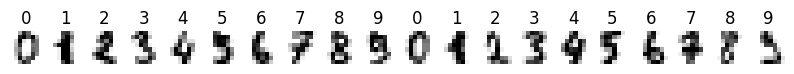

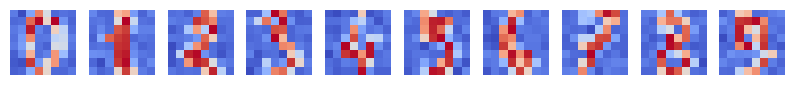

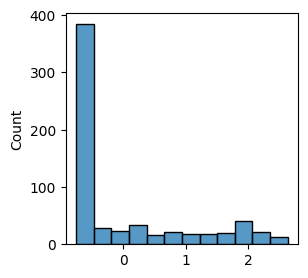

In [219]:
digits = fetch_digits_data()
train_data, _ = preprocess_digits_data(digits)

### Plot training data

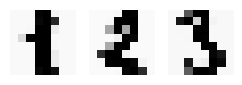

<Axes: ylabel='Count'>

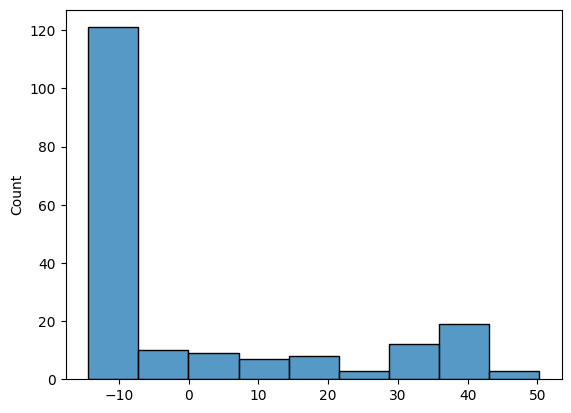

In [220]:
data = train_data[1:4].copy()
data *= 20

fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < data.shape[0]:
        image = data[i].reshape(8, 8) + np.random.normal(0, 0.1, (8,8)) 
        for j in range(image.shape[0]):
            for k in range(image.shape[1]):
                image[j, k] = Langevin(image[j, k])

        ax.imshow(image, cmap="gray_r", interpolation="nearest", vmin=-np.max(image), vmax=np.max(image))
        ax.set_axis_off()
    else:
        ax.set_visible(False)

plt.show()
sns.histplot(data.flatten())

## Training
### Set up the network

In [221]:
size = data.shape[1]
num_variables = data.shape[0]
J = np.zeros((size, size))
nw = AttractorNetwork(J, biases = np.zeros(J.shape[0]))

### Sequential training
Present data in a fixed order and extremely short epochs (1 step)

100%|██████████| 2000/2000 [00:11<00:00, 172.94it/s]


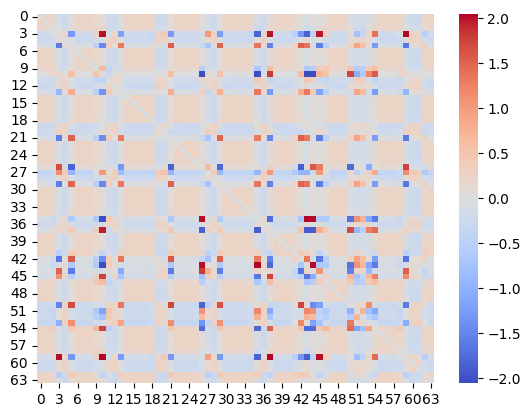

In [222]:
num_iterations = 2000

for i in tqdm(range(num_iterations)):
    di = i % data.shape[0] #np.random.randint(0, data.shape[0])
    activations, weight_change, accuracy, complexity, vfe = continous_inference_and_learning(
        nw=nw, 
        data=data[di], 
        inverse_temperature=1, 
        learning_rate=0.001, 
        num_steps=1)
    
sns.heatmap(nw.get_J(), cmap="coolwarm", center=0)
plt.show()

#for i, pattern_idx in enumerate(pattern):
#    plt.text(i*num_runs, max(error[i*num_runs:i*num_runs+num_runs]), str(pattern_idx), ha='center', va='bottom')


## Visualize the weight matrix and its symmetric and antisymmetric components

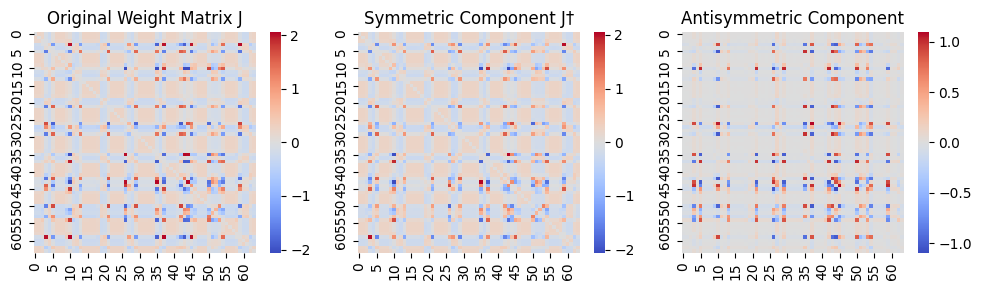

Asymmetry measure: 0.981247


In [223]:
# Symmetrize the weight matrix J
J = nw.get_J()
J_symmetrized = 0.5 * (J + J.T)  # J_ij† = (1/2) * (J_ij + J_ji)

# Display the original and symmetrized weight matrices
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
sns.heatmap(J, cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Original Weight Matrix J")

sns.heatmap(J_symmetrized, cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Symmetric Component J†")


# Calculate the asymmetric component of the weight matrix
J_asymmetric = 0.5 * (J - J.T)  # J_ij‡ = (1/2) * (J_ij - J_ji)

# Display the asymmetric component
sns.heatmap(J_asymmetric, cmap="coolwarm", center=0, ax=axes[2])
axes[2].set_title("Antisymmetric Component")
plt.tight_layout()
plt.show()



# Calculate and print the asymmetry measure
asymmetry = np.linalg.norm(J - J.T) / np.linalg.norm(J)
print(f"Asymmetry measure: {asymmetry:.6f}")


## Free-running (spontaneous activity) 

In [225]:
acts, weight_change, accuracy, complexity, vfe = continous_inference_and_learning(
    nw, np.zeros(data.shape[1]), inverse_temperature=1, 
    learning_rate=0, num_steps=100)

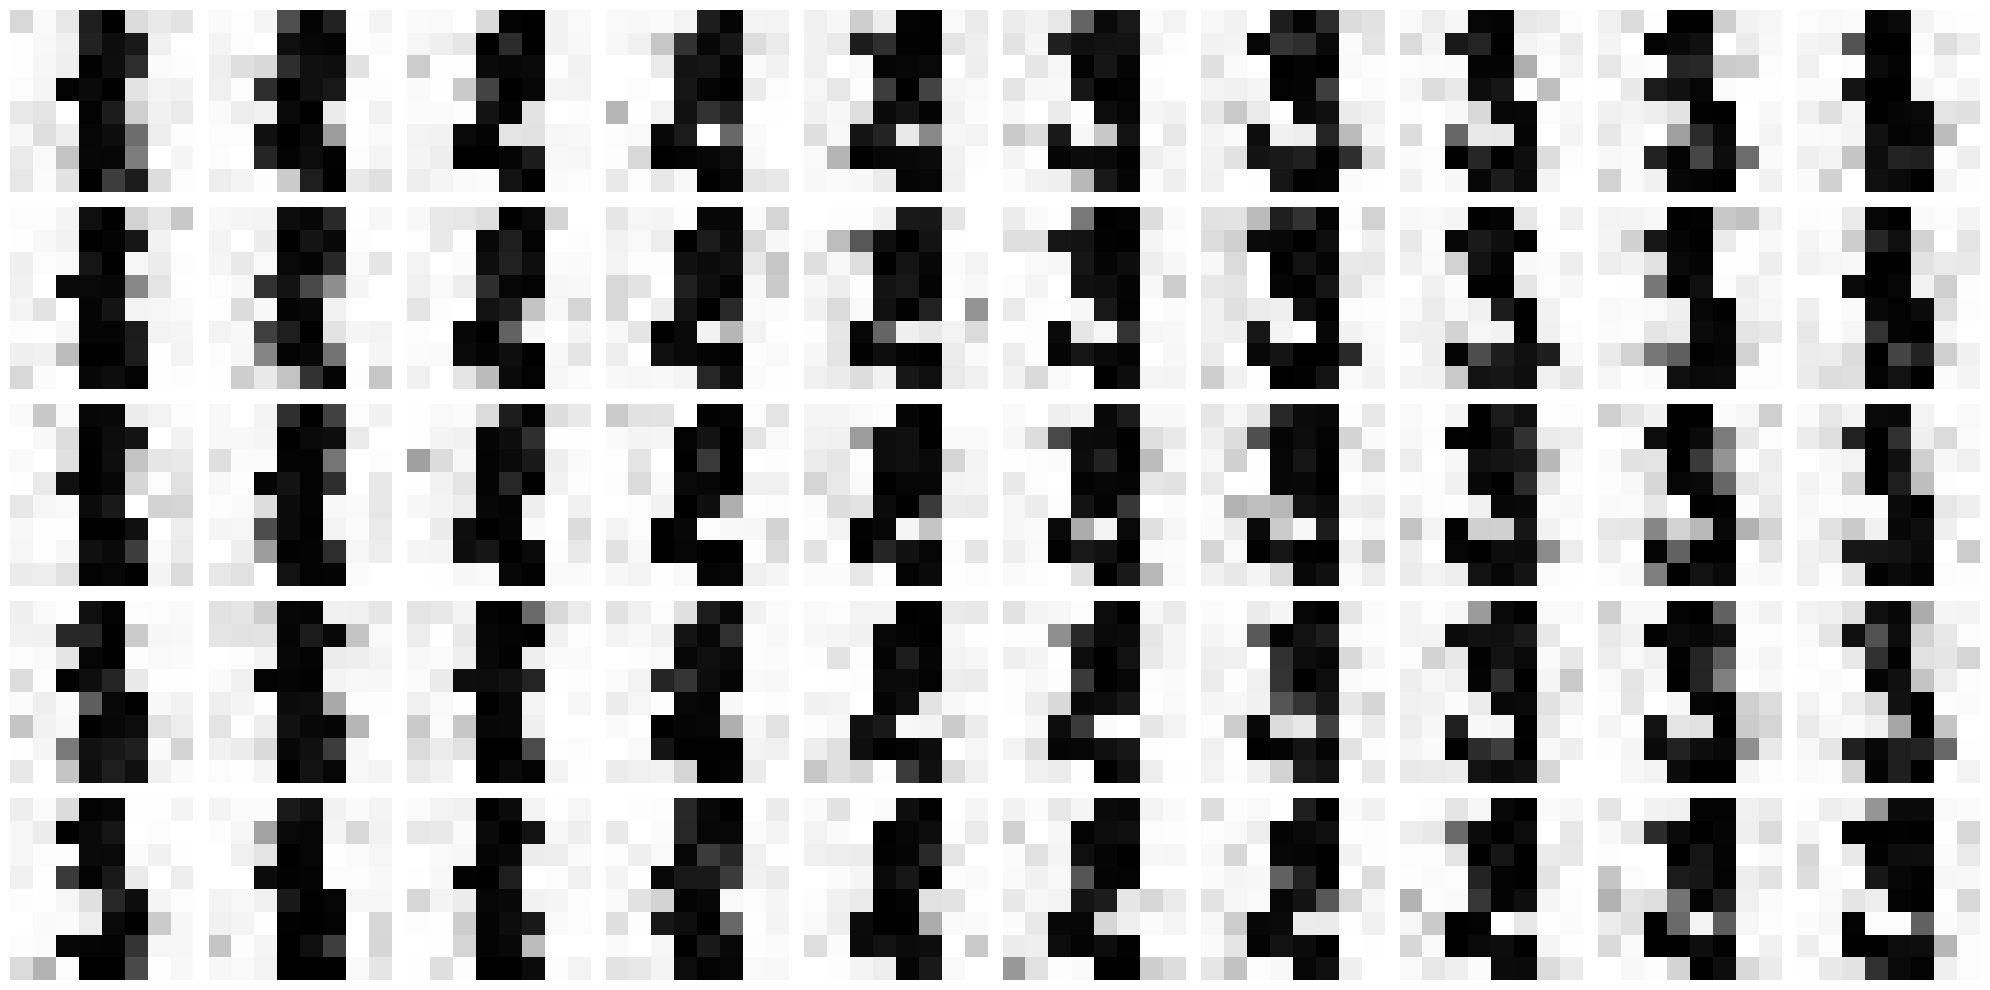

In [226]:
fig, axes = plt.subplots(5, 10, figsize=(20, 10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    sns.heatmap(np.array(acts[i+10]).reshape(8,8), cmap="gray_r", ax=ax, cbar=False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

## Attractors from the symmetric component

  ** Noise: 0


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


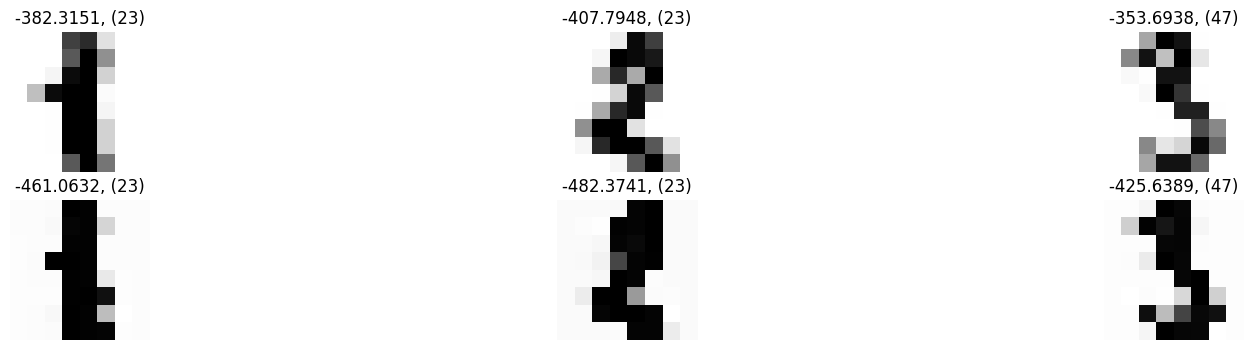

[array([-0.90288564, -0.90288734, -0.89395016,  0.92772164,  0.90749495,
        -0.90028988, -0.90216315, -0.90270948, -0.90288256, -0.90231346,
        -0.87466679,  0.8948815 ,  0.90994825, -0.6187639 , -0.90212455,
        -0.90255703, -0.90307682, -0.90252808, -0.89942102,  0.90867119,
         0.90704861, -0.89955458, -0.90247444, -0.90232051, -0.90299654,
        -0.89213355,  0.9190238 ,  0.93219895,  0.90873427, -0.90150859,
        -0.90267223, -0.90182199, -0.90294999, -0.90271066, -0.89998355,
         0.91462843,  0.90905729, -0.75843228, -0.90298625, -0.90265723,
        -0.90301133, -0.90503416, -0.90455038,  0.91211094,  0.93237412,
         0.80662162, -0.90336047, -0.90280665, -0.90293977, -0.90259084,
        -0.87176695,  0.92059984,  0.91000916, -0.44331117, -0.92467333,
        -0.90183692, -0.90296146, -0.90220506, -0.89362384,  0.92309671,
         0.90894171,  0.8974486 , -0.90722171, -0.90273355]),
 array([-0.90260279, -0.90234075, -0.90303629, -0.89376333,  0

In [238]:
nw_sym = AttractorNetwork(J_symmetrized, biases = np.zeros(nw.get_J().shape[0]))
get_deterministic_attractors(nw_sym, data, noise_levels=[0], inverse_temperature=1 )